# <font color="maroon">Chapter 6: Anatomy of pyDIFRATE</font>

pyDR uses extensive application of object-oriented programming in order to streamline detector analysis and ensure that data is correctly treated. The central object in pyDR is the 'data' object, which naturally contains dynamics data, but also contains all the other information about that data, and functions/objects for processing and data display. Data can be stored within a project, and data is created via loading NMR data from text or from processing MD data. The program structure is summarized in the figure below (although this is far from a comprehensive description). This tutorial investigates some of the components of pyDR, and discusses how they work together to simplify and accelerate processing for the user.

The figure below summarizes the structure/workflow of pyDR. Note that each box corresponds to an [object](https://en.wikipedia.org/wiki/Object_(computer_science)), in some cases being contained inside other objects. As one sees, most components of pyDR take advantage of [object-oriented programming](https://en.wikipedia.org/wiki/Object-oriented_programming) in order to improve the detector analysis workflow.

![pyDR program structure](https://raw.githubusercontent.com/alsinmr/pyDR_tutorial/main/JupyterBook/pyDR_structure.png)

## The Data Object
Central to pyDR functionality is the data object, which is responsible for storage of experimental and simulated data, as well as data produced by detector analysis. We will select a data object out of a recent project investigating Growth Hormone Secretagogue Receptor using MD simulation ([source](https://doi.org/10.1002/anie.202302003)). 

In [0]:
# SETUP pyDR
!git clone https://github.com/alsinmr/pyDR_tutorial.git
from pyDR_tutorial import colab_setup

In [2]:
#Imports
import pyDR
import numpy as np

In [3]:
#Load a project
proj=pyDR.Project('../GHSR_archive/Projects/backboneHN/')
data=proj[-2]  #Select a particular data object

### Data in the data object
Data can be found in data.R, with its standard deviation in data.Rstd. For NMR data, we may have $S^2$ data as well (data.S2,data.S2std). These fields are MxN, where M is the number of different locations in the simulation, and N is the number of data points (detectors, experiments, or correlation function time points) for each location.

In [4]:
print('Experimental data')
print(data.R)
print('Standard Deviation')
print(data.Rstd)

Experimental data
[[3.7942290e-01 2.1657662e-01 2.0262545e-01 ... 1.4402686e-01
  1.3009402e-01 5.9126038e-02]
 [2.5403091e-01 1.9350898e-01 2.0336972e-01 ... 1.8837723e-01
  2.1296179e-01 7.7475399e-02]
 [1.9356659e-01 1.3584794e-01 1.8840416e-01 ... 2.7771801e-01
  2.2354510e-01 1.0986746e-01]
 ...
 [9.7813830e-02 1.2932412e-02 1.8070474e-02 ... 6.8756002e-03
  7.5943240e-07 8.7012476e-01]
 [1.0092438e-01 1.7791813e-02 2.7242884e-02 ... 4.0566847e-02
  6.9016963e-03 8.2861245e-01]
 [2.8222382e-01 3.0010650e-01 2.3420739e-01 ... 4.6467399e-03
  3.1937913e-07 3.5440496e-01]]
Standard Deviation
[[0.00086905 0.00158777 0.00125429 ... 0.00130778 0.0014115  0.00074924]
 [0.00086905 0.00158777 0.00125429 ... 0.00130778 0.0014115  0.00074924]
 [0.00086905 0.00158777 0.00125429 ... 0.00130778 0.0014115  0.00074924]
 ...
 [0.00086905 0.00158777 0.00125429 ... 0.00130778 0.0014115  0.00074924]
 [0.00086905 0.00158777 0.00125429 ... 0.00130778 0.0014115  0.00074924]
 [0.00086905 0.00158777 0.001

### Sensitivity of the data object
Each data point in a simulation has its own sensitivity. To know the significance of a data point, we naturally need to know the sensitivity of each data point, so it makes sense to always store the sensitivity object along with the data object. It is found in data.sens. A few key components are found in the sensitivity object.
```
.tc        correlation time vector (default 10 fs to 1 ms, 200 points)
.z         log-correlation time (default -14 to -3, 200 points)
.rhoz      Sensitivity of the data as a function of correlation time
           (NxM, where N is the number of data points, M is the number of times in the correlation time axis)
.plot_rhoz Plots rhoz vs. tc
.info      Parameters describing (or used to calculate) the sensitivities
.Detector  Produces a detector object from the sensitivity object
```
Here, we plot the sensitivity of the data for example

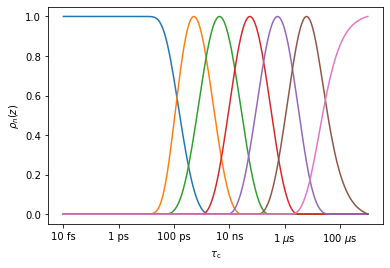

In [5]:
_=data.sens.plot_rhoz()

We see that there are seven detectors space from below (\~100 ps) to above (\~3 $\mu$s). From sens.info, we can find out the mean position of the detectors (here, we convert from the log scale to ns). Note that the first and last detector do not really have a mean position (although one is nonetheless calculated), since they remain positive for arbitrarily short/long correlation times, respectively

In [6]:
for k,z0 in enumerate(data.sens.info['z0']):
    print(f'rho{k}: ~ {10**z0*1e9:.2} ns')

rho0: ~ 0.0013 ns
rho1: ~ 0.58 ns
rho2: ~ 4.3 ns
rho3: ~ 5.5e+01 ns
rho4: ~ 5.3e+02 ns
rho5: ~ 7e+03 ns
rho6: ~ 1.4e+05 ns


The sens.info object is particularly useful in summarizing relevant parameters for the sensitivity of a given data object. It is also accessible via data.info. Note that sens.info for an NMR or MD sensitivity yields parameters from which the sensitivities may be calculated, whereas for detectors, sens.info only characterizes the sensitivities, but cannot calculation them. We show below the sensitivity of this data (detectors), but also create an NMR sensitivity object, and show info, to highlight the differences.

In [7]:
print('Info for detector:')
print(data.info)
nmr=pyDR.Sens.NMR(Nuc='15N',Type='R1',v0=[400,600,800])
print('\n\nInfo for NMR sensitivity:')
print(nmr.info)

Info for detector:
                 0           1           2           3           4           5           6
z0      -11.887198  -9.2347894  -8.3647531  -7.2601854  -6.2729486  -5.1564855  -3.8648295
zmax    -12.728643  -9.3015075  -8.3618090  -7.2562814  -6.2613065  -5.2110552        -3.0
Del_z   4.24162168  1.46730976  1.65835556  1.60612970  1.62059535  1.61260870  1.61039228
stdev   0.00150523  0.00275009  0.00217250  0.00231370  0.00226514  0.00244478  0.00129772

[7 experiments with 4 parameters]


Info for NMR sensitivity:
                 0         1         2
Type            R1        R1        R1
v0             400       600       800
v1               0         0         0
vr               0         0         0
offset           0         0         0
stdev            0         0         0
med_val          0         0         0
Nuc            15N       15N       15N
Nuc1            1H        1H        1H
dXY       -22954.8  -22954.8  -22954.8
CSA          113.0     113.0     1

### Detectors for the data object
The next critical component of the data object is the Detector object (data.detect). The detector object provides the instructions on how to fit the data (when calling data.fit()). The detector object is derived from the sensitivity object (data.detect=data.sens.Detector()), and the detector object always contains the original data object (data.detect.sens). We can demonstrate this below.

In [8]:
# Demonstrate that the detector object contains the sensitivity object
print('Is the detector object\'s sensitivity the same and the sensitivity of the data?')
print(data.sens is data.detect.sens)
# Produce the detector object from the sensitivity object
r=data.sens.Detector() #Produce a detector object from a sensitivity object

Is the detector object's sensitivity the same and the sensitivity of the data?
True


Then, the detector object can be optimized in a variety of ways for data analysis. However, it is not recommended to re-analyze data that has already been analyzed with detectors *unless* un-optimized detectors have been used. Then, we will demonstrate based on the original sensitivity object for this data set. It has gone through two layers of processing, so we have to go two sensitivities back.

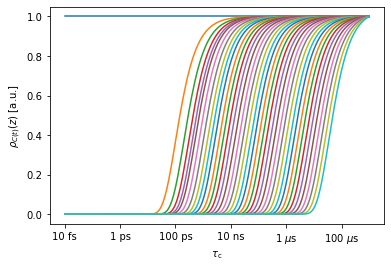

In [9]:
sens=data.sens.sens.sens
_=sens.plot_rhoz()  #This plots only a selection of MD sensitivities by default

We first create a detector object from the sensitivity object. pyDR does this automatically when a data object is created (data.detect=data.sens.Detector()). However, here, we have to do this step ourselves.

In [10]:
r0=sens.Detector()

For NMR data, we usually just optimize the detectors with 'detect.r_auto', but for MD, we often take an intermediate step, using detect.r_no_opt()

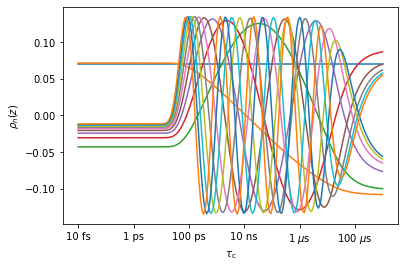

In [11]:
r0.r_no_opt(12)     #Create detectors with r_no_opt, using 12 detectors
_=r0.plot_rhoz()    #Plot the result

The raw correlation function data can be fitted with the *unoptimized* detectors and stored, which vastly reduces the data size, but loses very little correlation time information. In a subsequent step, one can use 'r_auto'. Once data has been processed with detectors using 'r_auto' or 'r_target', the data should ideally not be reprocessed (rather, go back to the unoptimized detectors, and apply differnet processing from there).

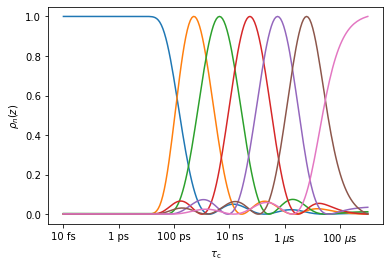

In [12]:
r1=r0.Detector()  #Create another detector
r1.r_auto(7)      #Create 7 optimized detectors
_=r1.plot_rhoz()  #Plot the results

It is important to note: we get the same detectors going directly from MD data to optimized detector windows as if we go via two steps, using unoptimized detector windows in between. Copy the following code into a cell if you want to check.
```
r2=sens.Detector() #Detectors generated from the original sensitivity
r2.r_auto(7)       #Create 7 optimized detectors
ax=r2.plot_rhoz()[0].axes #Plot the result
_=r1.plot_rhoz(ax=ax,color='black',linestyle=':')  #Overlay the results
```

### Fitting results in the data object
A data object, by default contains (or can back calculate), the results of fitting. These results are found in data.Rc. Note a data object usually also contains a reference to the original (source) data (data.src_data), although if the source data consisted of long correlation functions, then it is usually discarded if the data is saved and reloaded.
```
data.Rc   #Back-calculated parameters 
data.src_data #Reference to the original data object
```
A comparison of the back-calculated data and the original data may be obtained with data.plot_fit(). In this example, the source data was the result of first fitting to 15 unoptimized detectors and subsequently fitting with seven optimized detectors. The result is that the first 7 unoptimized detectors are almost perfectly fit (with small error due to bounds placed on the result– eliminating the bounds will eliminate the error), but the latter 8 detectors are not fit at all. This comes about because the 7 optimized detectors use exactly the first 7 singular values to fit the data, and discard the latter 8. 

In [10]:
data.Rc

array([[ 7.05541598e-02,  1.31131795e-02,  1.56836598e-02, ...,
         2.72427192e-12,  9.10197174e-13,  9.64890409e-14],
       [ 7.06657670e-02, -6.53508201e-03,  2.49433414e-02, ...,
         6.03828888e-12,  1.02053561e-12, -4.07342574e-14],
       [ 7.07414883e-02, -2.08076652e-02,  2.92742123e-02, ...,
         4.99809518e-13,  7.92258083e-14, -2.48752729e-13],
       ...,
       [ 7.05414347e-02, -8.72078078e-02, -8.89642359e-02, ...,
        -1.14633327e-11,  2.81733530e-12,  2.85738900e-12],
       [ 7.05249584e-02, -8.40580211e-02, -8.18875549e-02, ...,
        -1.26868845e-11,  2.43656332e-12,  2.64733752e-12],
       [ 7.09807861e-02, -7.09484324e-03, -2.35905914e-02, ...,
        -3.47984956e-12,  2.93911542e-12,  1.81354237e-12]])

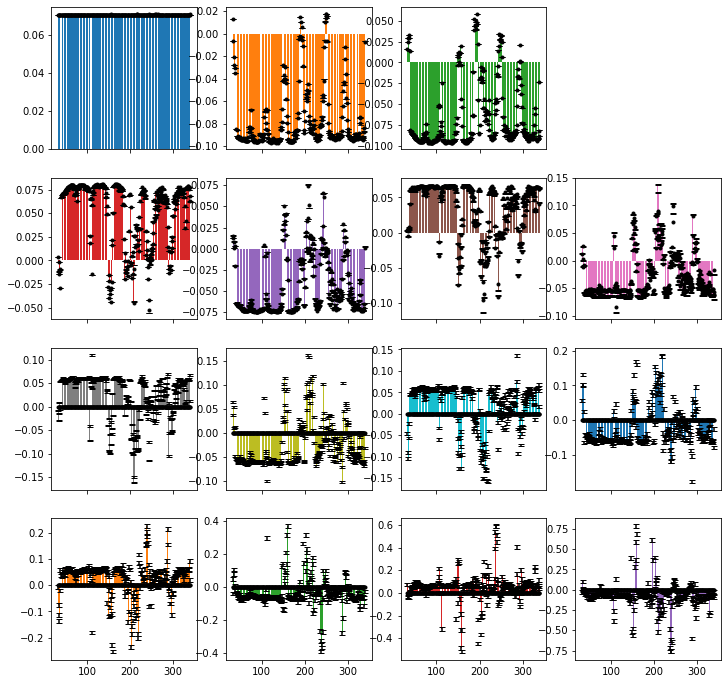

In [5]:
data.plot_fit()[0].figure.set_size_inches([12,12])

Below, we print the median relative error for each detector. Note that there is some error for the first seven detectors. This comes because non-exponentiality in the correlation functions (from noise or other sources) may lead to an unphysical set of unoptimized detectors, where bounds on the optimized detectors eliminates some of this unphysicality, but results in mis-fit of the unoptimized detectors. This error can be eliminated by not enforcing the bounds (as done below in fit_nobounds).

In [9]:
fit_nobounds=data.src_data.fit(bounds=False)
print('Relative error')
print('Detector w/ bounds w/o bounds')
for k,(R,Rc,Rcnb) in enumerate(zip(data.src_data.R.T,data.Rc.T,fit_nobounds.Rc.T)):
    error=np.median(np.abs((R-Rc)/R))
    error_nb=np.median(np.abs((R-Rcnb)/R))
    print(f'  rho{k}: {error:<9.2} {error_nb:.2}')

Data already in project (index=12)
Relative error
Detector w/ bounds w/o bounds
  rho0: 0.0024    1.5e-08
  rho1: 0.0018    2.1e-08
  rho2: 0.0062    2.1e-08
  rho3: 0.011     2.4e-08
  rho4: 0.016     2.3e-08
  rho5: 0.04      2.3e-08
  rho6: 0.13      2e-08
  rho7: 1.0       1.0
  rho8: 1.0       1.0
  rho9: 1.0       1.0
  rho10: 1.0       1.0
  rho11: 1.0       1.0
  rho12: 1.0       1.0
  rho13: 1.0       1.0
  rho14: 1.0       1.0


### Data displays in the data object
While all the theoretical efforts going into pyDR are important, it is equally critical to easily visualize our data. The pyDR data object implements then the .plot function, as well as extensive functionality for 3D visualization in [ChimeraX](https://www.cgl.ucsf.edu/chimerax/) and more limited visualization in [NGL viewer](https://nglviewer.org/).
```
data.plot()
data.chimeraX()
data.nglview(rho_index)  
```
We show data.plot below. ChimeraX will only work locally. It can be launched from Jupyter, but runs as a separate program, whereas Colab does not support its running separately from the Colab notebook. NGL viewer runs in both Jupyter and Colab cells, but rendering in Colab often fails partway through. This appears to be a Colab problem, rather than an NGLview or pyDR problem (since it works locally).

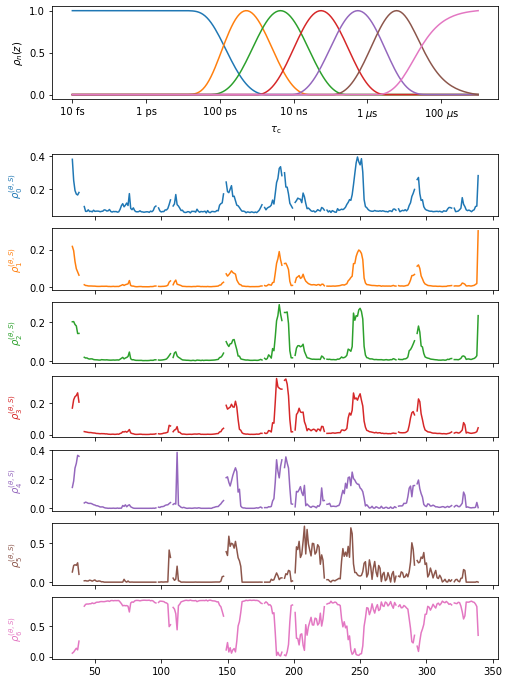

In [10]:
proj.close_fig('all')
data.plot().fig.set_size_inches([8,12])

Below, we execute chimera (won't work in Colab). Once the molecule is open in ChimeraX, you can mouse over the different detectors in the upper right corner to see the different detector responses.

In [7]:
# pyDR.chimeraX.chimeraX_funs.set_chimera_path('path_to_executable') #Needs to be run once
data.chimera()
proj.chimera.command_line(['~show ~@N,C,CA','set bgColor white','lighting soft'])  #Send a command to ChimeraX to adjust the view

### Selections in data object
Our ability to plot data onto the molecule, and also to compare data from different sources to the same positions on the molecule comes from the association of the dynamics data with particular bonds on a molecule. This association is defined by the MolSelect (data.select) object. The key components of this object are the bond selections (defined by .sel1, .sel2), the "representative selection", which usually contains the atoms in sel1 and sel2, but may contain additional atoms to improve visibility of the dynamics (e.g. for H–N motion, we include the whole peptide plane in the representative selection). The selection object also suggests a unique set of labels for the set of bonds in the selection object (used for MD labeling), which are often assigned to the data object upon data generation from MD simulations.
```
data.select.sel1  #First atom in bond
data.select.sel2  #Second atom in bond
data.select.repr_sel #Atoms on which to encode data
data.label  #Unique set of labels for selected bonds
```

### Source information in data object
pyDR keeps careful track of where data came from, to avoid later confusion on what happened in a data processing procedure. It is also important to automatically organize data in projects. This is largely managed by the data.source object. We will not list all attributes of data.source here, but note that a few critical ones are
```
.source.filename:   File or list of files from which data is derived
.source.short_file: Shortened version of above (just one string)
.source.status:     Processing status of the data (raw,no_opt,proc,opt_fit, abbreviated as r,n,p,o)
.source.Type:       Type of data (NMR,MD,FRAMES,IRED, etc.)
.source.additional_info Additional data description
.source.n_det       Number of detector (if not raw data)
.source.title       Title constructed from the above information
```
For example, the title of our example data object is 
**o7:FRAMES:AvOb:WT-apo_run1_0.1ns_just_protein**
which means:
* o: Optimized fit (status)
* 7: Seven detectors (n_det)
* FRAMES: Data extracted from a frames analysis (Type)
* AvOb: Data was averaged over several data objects (additional_info)
* WT-apo_run1_0.1ns_just_protein (short_file)

Note that data.source and the project work together to make sure that there are unique names for saving data. Titles need not be unique. 

Also note: the user may overwrite the data title if desired, but the corresponding project object must be informed of this action manually.
```
data.title='new_title'
proj.update_info()  
```

In [38]:
print(data.source.status)
print(data.source.n_det)
print(data.source.Type)
print(data.source.additional_info)
print(data.source.short_file)
print(data.source.title)
print(data.title)  #This references data.source.title

opt_fit
7
Frames
AvOb
WT-apo_run1_0.1ns_just_protein.xtc
o7:FRAMES:AvOb:WT-apo_run1_0.1ns_just_protein
o7:FRAMES:AvOb:WT-apo_run1_0.1ns_just_protein


data.source also keeps a detailed, plain text processing history (data.source.details). It can also be accessed from data.details. This particular data set was obtained using averages over 3 MD trajectories and each trajectory was chunked by residue into 5 parts, so there are 15 combined data objects, making the details much longer than usual. We print part of the details here.

In [47]:
for k in range(10):print(data.details[k])
print('...')
for k in range(-10,0):print(data.details[k])

Average of 3 data objects
START DATA OBJECT 0
Appending 5 data objects
START DATA OBJECT 0
Topology: /work/public/ghrelin-receptor/WT-apo_run1_just_protein.pdb
Trajectory:/work/public/ghrelin-receptor/WT-apo_run1_0.1ns_just_protein.xtc
t0=0, tf=355000, step=1, dt=100.0 ps, original length=372685
Selection with 59 elements
...
Rotation between frames PAS and superimpose
Fitted with 15 detectors (bounds:False)
Detector optimization type: no_opt
Normalizaton: None, NegAllow: False, Options:
END DATA OBJECT 4
END DATA OBJECT 2
Fitted with 7 detectors (bounds:True)
Detector optimization type: auto
Normalizaton: MP, NegAllow: False, Options:
Data fit optimized with opt2dist (rhoz_cleanup:True)


## The Project Object

While Projects are not required for using pyDR, they are particularly helpful in organizing/processing/saving/displaying data. They provide a straightforward data sorting mechanism, and automatically manage the displaying of data, including data superposition. They also allow execution of processing commands on multiple data sets at once. 

We can see what's in a project, just by typing the variable name:

In [48]:
proj

pyDIFRATE project with 13 data sets

Titles:
n15:FRAMES:WT-apo_run1_0.1ns_just_protein
n15:FRAMES:WT-apo_run2_0.1ns_just_protein
n15:FRAMES:WT-apo_run3_0.1ns_just_protein
n15:FRAMES:WT-ghrelin_run1_0.1ns_just_protein
n15:FRAMES:WT-ghrelin_run2_0.1ns_just_protein
n15:FRAMES:WT-ghrelin_run3_0.1ns_just_protein
n15:FRAMES:AvOb:WT-apo_run1_0.1ns_just_protein
n15:FRAMES:AvOb:WT-ghrelin_run1_0.1ns_just_protein
p7:FRAMES:AvOb:WT-apo_run1_0.1ns_just_protein
p7:FRAMES:AvOb:WT-ghrelin_run1_0.1ns_just_protein
o7:FRAMES:AvOb:WT-apo_run1_0.1ns_just_protein
o7:FRAMES:AvOb:WT-ghrelin_run1_0.1ns_just_protein
o7:FRAMES:AvOb:WT-ghrelin_run1_0.1ns_just_protein1


### Project data selection
It's possible to select one or more data objects out of a project using a variety of methods:
```
proj[0] : Single index returns one data object
proj[1:5:2] : Slicing returns several elements of the project 
proj[[1,2,4]] : List returns selected elements of project
proj['proc'] : Keywords return parts of project
proj['.+AvOb.+apo'] : Regular expressions filter project based on title
proj['opt_fit']['.+apo'] : String together multiple fills

proj['opt_fit']+proj['WT-apo'] : Combine subprojects (must be the same parent project)
proj['opt_fit']-proj['.ghrelin'] : Intersection of projects
```

Note: a single index returns a data object. All other methods return a subproject, even if that subproject only contains a single data object. However, most attributes of the data object in a subproject with only one element are accessible directly from the subproject, e.g.
```
proj['opt_fit']['.+WT-apo'].R
```
yields the data in the selected data object

In [60]:
proj['.+AvOb.+apo']

pyDIFRATE project with 3 data sets

Titles:
n15:FRAMES:AvOb:WT-apo_run1_0.1ns_just_protein
p7:FRAMES:AvOb:WT-apo_run1_0.1ns_just_protein
o7:FRAMES:AvOb:WT-apo_run1_0.1ns_just_protein


In [61]:
proj['opt_fit']['.+apo']

pyDIFRATE project with 1 data sets

Titles:
o7:FRAMES:AvOb:WT-apo_run1_0.1ns_just_protein


As mentioned above, subprojects with only one data object automatically obtain attributes of that data object (unless project already has the attribute– e.g., a subproject always uses the proj.chimera object, rather than the data.chimera function. Usually, the user will not notice the difference, but occasionally this can become important. Here we demonstrate how the full project has no attribute 'R', but a subproject with a single element does have 'R'.

In [8]:
hasattr(proj,'R')

False

In [9]:
hasattr(proj['opt_fit']['.+apo'],'R')

True

### Project batch processing
The functions .fit, .opt2dist, and .modes2bonds (iRED) can be applied to a (sub-)project and will be applied to all data within. Also, proj.detect allows batch optimization of detectors. In fact, the project will test to see if some of the detector objects are originating from identical sensitivities and will replace them with a unified object if so, avoiding redundant detector optimization. We'll show the procedure for re-fitting some of the no-opt data.

In [4]:
proj['no_opt']['AvOb'].detect.r_auto(8)  #OPtimize detectors
_=proj['no_opt']['AvOb'].fit()

Fitted 2 data objects


We can check and see that indeed the detector objects in the subproject are now the same object, thus removing the need to optimize both.

In [5]:
proj['no_opt']['AvOb'][0].detect is proj['no_opt']['AvOb'][1].detect

True

In most cases, this will not cause the user any problems, but one needs to be aware that subsequent detector optimizations of either of the detectors will automatically be applied to both. This behavior can be avoided by enforcing *unique detectors*

In [6]:
proj['no_opt']['AvOb'].detect.unique_detect()
proj['no_opt']['AvOb'][0].detect is proj['no_opt']['AvOb'][1].detect

False

### Project plotting
When we plot data contained in a project, it is automatically plotted into a *plot object* contained within the project (proj.plt_obj). A project has an active plot object (proj.current_plot, indexed from 1), but may also have inactive plots. When plotting, data always goes into the active plot. To create a blank plot object, just change the current_plot to an unused value (or close all plots, proj.close_fig('all')).

Note that you can capture the plt_obj after plotting, or obtain the current plot object from proj.plt_obj. 

plt_obj contains access to the various axes (.ax, .ax_sens) and figure (.fig). plt_obj.show_tc() will display the average correlation time for each detector on the corresponding plot.

Note that assignment of the plt_obj to a variable will suppress its display, and will need to be called later.

Plot object plots can be saved to the project folder by calling:
```
proj.savefig(filename)
```
Plots may also be saved outside the project folder by providing the full path.

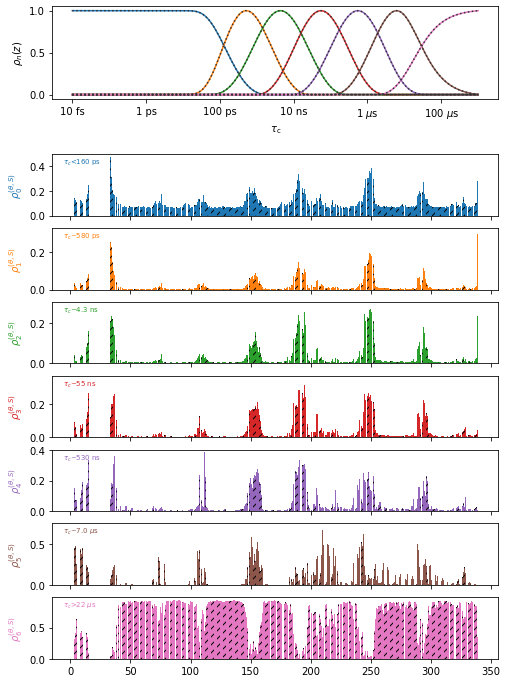

In [7]:
proj.close_fig('all')
proj['o7'].plot(style='bar').show_tc().fig.set_size_inches([8,12]) 
#Create the plot, show correlation times in the plot, adjust the figure size

In the above plot, it is difficult to see the differences between the two data objects (data sets are differentiated by hashes on the bars), so we can instead plot them with two different plot types (plot types are line plots: 'p', bar plots: 'b', and scatter plots: 's')

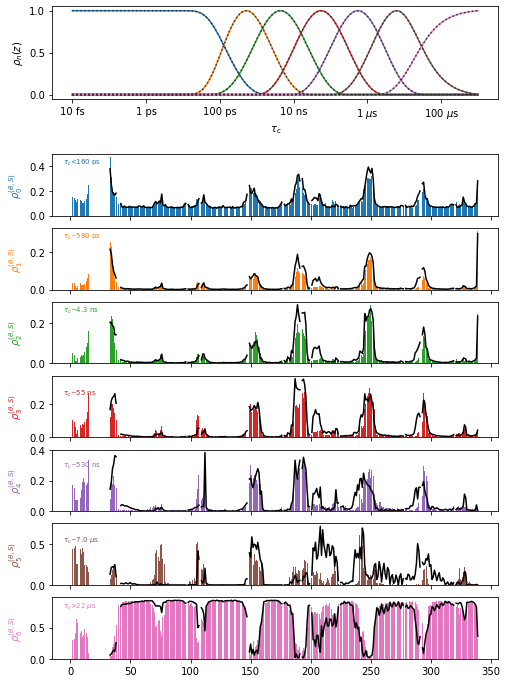

In [16]:
proj.close_fig('all')
proj['o7.+ghrelin'].plot(style='bar').show_tc().fig.set_size_inches([8,12])
proj['o7.+apo'].plot(style='plot')

### ChimeraX in projects
proj.chimera also provides special functionality. For example, when calling chimera for data within a project, by default, the project will retain communcation with the chimeraX instance such that one may add additional molecules to it, send commands to chimeraX via the command line, and save the results. We can also use multiple chimera instances (tested on Mac/Linux), by changing current.

Note that occasionally, communication with ChimeraX is lost for one reason or another. pyDR should automatically create a new instance/connection, but the previous instance will need to be manually closed.
```
proj.chimera()           :  Send all data sets in the project to chimera
.chimera.command_line    :  ChimeraX command or list of commands
.chimera.savefig         :  Saves the figure (goes into project folder unless full path given!)
.chimera.current         :  Switch the current chimera instance (not a function- just set the value)
.chimera.close           :  Close the specified model in chimera (or leave blank for all models)


In [14]:
proj['o7'].chimera()  #Show two data sets in chimera
proj.chimera.command_line('~show ~@N,C,CA')  #Just show the backbone

### Project saving/loading
When a project is created, we may specify a directory to allow that project later to be saved (projects consist of folders). Note that we may also create an empty project without a directory but then it will not be possible to save the project later. Note that if we are making a new project, we must specify create=True.

A project is saved simply by specifying proj.save()
```
proj=pyDR.Project('my_new_project',create=True)  #create a new project
proj=pyDR.Project('my_existing_project')         #load an existing project
proj.save()
```
Note that proj.save will exclude large, raw MD data sets by default, since they may take gigabytes of space (whereas a typical project is usually a few MB). Set include_rawMD=True to override this behavior.

Projects also manage memory/time by only loading data that has actually been requested. Then, opening a project is fast, but the first access to a data set in the project may take some time (usually also short except for large data sets). proj.clear_memory will remove references to all data sets from the project, although this does not guarantee a data cleanup, and therefore reduced memory, if other references exist.

## Data Generation
The final question in this chapter, is how do we get data in the first place, and how do we put it into projects?

NMR data is already prepared and stored in a text file. Then, we may either load the data object and then append to a project, or just provide the path/link to the project directly. We'll make an empty project to test this.

In [10]:
proj=pyDR.Project()  #Project (without directory)

nmr_data=pyDR.IO.readNMR('data/ubi_soln.txt')  #File path
proj.append_data(nmr_data)

proj.append_data('https://drive.google.com/file/d/1w_0cR6ykjL7xvdxU2W90fRXvZ8XfLFc3/view?usp=share_link') #Online link
proj

pyDIFRATE project with 2 data sets

Titles:
r:NMR:ubi_soln
r:NMR:1w_0cR6ykj


The second way we get data into a project is by processing data already stored in a project

In [11]:
proj[0].detect.r_auto(4)
proj[0].fit()

p4:NMR:ubi_soln with 63 data points


In [9]:
proj

pyDIFRATE project with 3 data sets

Titles:
r:NMR:ubi_soln
r:NMR:1w_0cR6ykj
p4:NMR:ubi_soln


As one sees, after processing the first data object in the project, we obtain a new data object– any new data created out of a project is automatically appended to it.

For MD data, we first create a selection object. The simplest way to get MD data to a project is to add the project to the original selection object, which will cause any data produced from that selection object to go automatically into the project. We may also use proj.append_data after the data creation if desired.

In [17]:
sel=pyDR.MolSelect(topo='../pyDR/examples/HETs15N/backboneB.pdb',
                   traj_files='../pyDR/examples/HETs15N/backboneB.xtc',
                   project=proj) #Create a selection object
sel.traj.step=10 #Adjust time step for faster loading
pyDR.Defaults['ProgressBar']=False  #Turn off progress bar for webpage
sel.select_bond('N',segids='B')
pyDR.md2data(sel)

r:MD:backboneB with 70 data points


If we check, we find indeed that the raw data has now appeared in the project

In [18]:
proj

pyDIFRATE project with 15 data sets

Titles:
n15:FRAMES:WT-apo_run1_0.1ns_just_protein
n15:FRAMES:WT-apo_run2_0.1ns_just_protein
n15:FRAMES:WT-apo_run3_0.1ns_just_protein
n15:FRAMES:WT-ghrelin_run1_0.1ns_just_protein
n15:FRAMES:WT-ghrelin_run2_0.1ns_just_protein
n15:FRAMES:WT-ghrelin_run3_0.1ns_just_protein
n15:FRAMES:AvOb:WT-apo_run1_0.1ns_just_protein
n15:FRAMES:AvOb:WT-ghrelin_run1_0.1ns_just_protein
p7:FRAMES:AvOb:WT-apo_run1_0.1ns_just_protein
p7:FRAMES:AvOb:WT-ghrelin_run1_0.1ns_just_protein
o7:FRAMES:AvOb:WT-apo_run1_0.1ns_just_protein
o7:FRAMES:AvOb:WT-ghrelin_run1_0.1ns_just_protein
p8:FRAMES:AvOb:WT-apo_run1_0.1ns_just_protein
p8:FRAMES:AvOb:WT-ghrelin_run1_0.1ns_just_protein
r:MD:backboneB


In the subsequent tutorials, we'll also see how to generate data from the ROMANCE (frames) and cross-correlation (iRED) modules.